# Manipulation de la Donnée

## Téléchargement des données

In [122]:
!pip install kaggle

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Chargement des données

In [124]:
import pandas as pd

imdb_df = pd.read_csv("/content/IMDB Dataset.csv")

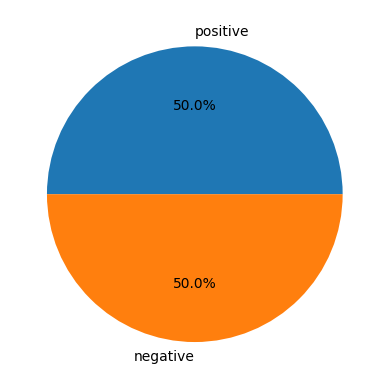

In [125]:
import matplotlib.pyplot as plt

sentiment_counts = imdb_df['sentiment'].value_counts()

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.show()

## Nettoyage et Prétraitement des Textes

### Suppression des tags html du contenu de la colonne review

In [126]:
from bs4 import BeautifulSoup

imdb_df['review'] = imdb_df['review'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

<ipython-input-126-f0b0e7e04f1f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  imdb_df['review'] = imdb_df['review'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


### Suppression de la ponctuation


In [127]:
import string

imdb_df['review'] = imdb_df['review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

### Passage en minuscules (lowercase)

In [128]:
imdb_df['review'] = imdb_df['review'].apply(lambda x: x.lower())

### Suppression des stop words

In [129]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

imdb_df['review'] = imdb_df['review'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lemmatisation



In [130]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [131]:
from textblob import Word
imdb_df['review'] = imdb_df['review'].apply(lambda x: " ".join([Word(word).
lemmatize() for word in x.split()]))

## Tokenisation et Padding et Encodage des Labels

In [132]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import spacy

In [133]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(imdb_df['review'])
sequences = tokenizer.texts_to_sequences(imdb_df['review'])

padded_sequences = pad_sequences(sequences)
imdb_df['padded_sequences'] = list(padded_sequences)

label_encoder = LabelEncoder()
imdb_df['encoded_label'] = label_encoder.fit_transform(imdb_df['sentiment'])

In [134]:
imdb_df

,review,sentiment,padded_sequences,encoded_label
0,one reviewer mentioned watching 1 oz episode y...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,wonderful little production filming technique ...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,thought wonderful way spend time hot summer we...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,basically there family little boy jake think t...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,petter matteis love time money visually stunni...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...
49995,thought movie right good job wasnt creative or...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
49996,bad plot bad dialogue bad acting idiotic direc...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
49997,catholic taught parochial elementary school nu...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
49998,im going disagree previous comment side maltin...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


## Séparation des données

In [135]:
from sklearn.model_selection import train_test_split

X = padded_sequences

y = imdb_df['encoded_label']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Entraînement de 3 Modèles

In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

##Modèle LSTM from scratch :

In [137]:
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [138]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

In [139]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [140]:
history = model_lstm.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, lr_decay])

Epoch 1/50
1000/1000 [==============================] - 158s 155ms/step - loss: 0.3759 - accuracy: 0.8346 - val_loss: 0.3087 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - 111s 111ms/step - loss: 0.2615 - accuracy: 0.8977 - val_loss: 0.3071 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - 102s 102ms/step - loss: 0.2225 - accuracy: 0.9154 - val_loss: 0.3134 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 4/50
1000/1000 [==============================] - 99s 99ms/step - loss: 0.1754 - accuracy: 0.9351 - val_loss: 0.3919 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 5/50
1000/1000 [==============================] - 97s 97ms/step - loss: 0.1030 - accuracy: 0.9668 - val_loss: 0.3828 - val_accuracy: 0.8751 - lr: 1.0000e-04


In [143]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## Predict classes or probabilities for the test data

In [144]:
y_pred = model_lstm.predict(X_test)

313/313 [==============================] - 11s 36ms/step


In [145]:
# Calculate accuracy
# accuracy = accuracy_score(Y_test, y_pred)

# Calculate AUC
auc = roc_auc_score(Y_test, y_pred)

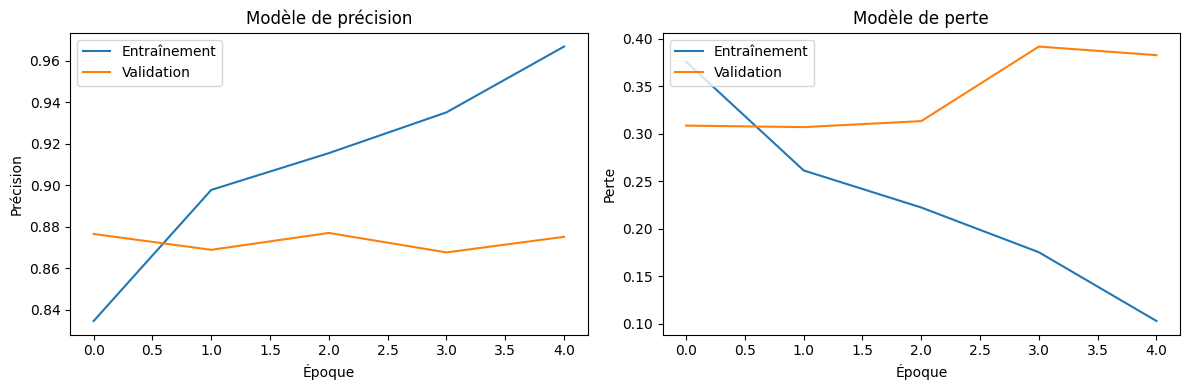

250/250 [==============================] - 11s 44ms/step


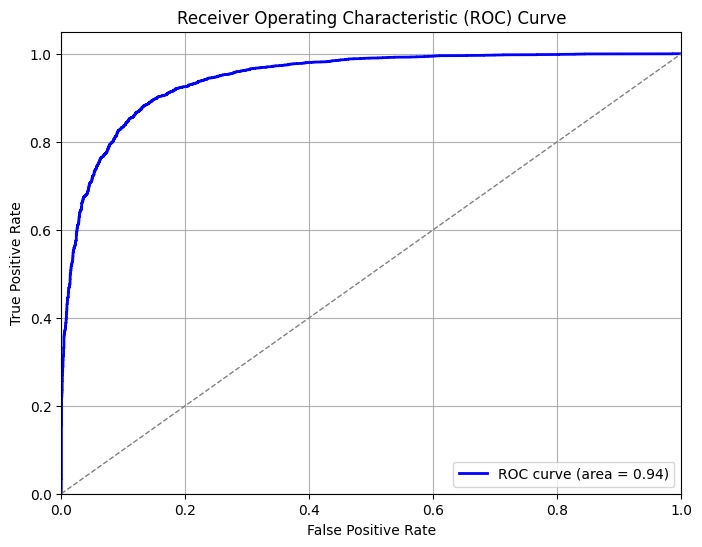

In [146]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


def plot_learning_curves(history):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Modèle de précision')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend(['Entraînement', 'Validation'], loc='upper left')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Modèle de perte')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend(['Entraînement', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


from sklearn.metrics import roc_auc_score

def plot_roc_curve(model, X_val, Y_val):

    Y_pred_prob = model.predict(X_val)

    fpr, tpr, _ = roc_curve(Y_val, Y_pred_prob)


    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_curve(model_lstm, X_val, Y_val)


##Modèle LSTM avec Attention :

In [147]:
max_sequence_length = 100  # Desired sequence length
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val, maxlen=max_sequence_length)

In [148]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention
from tensorflow.keras.models import Model

input_layer = Input(shape=(100,))

embedding_layer = Embedding(input_dim=5000, output_dim=128)(input_layer)

lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)

attention_layer = Attention()([lstm_layer, lstm_layer])

output_layer = Dense(units=1, activation='sigmoid')(attention_layer)  # for binary classification

model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)

model_lstm_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm_attention.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 100, 128)             640000    ['input_15[0][0]']            
                                                                                                  
 lstm_22 (LSTM)              (None, 100, 128)             131584    ['embedding_20[0][0]']        
                                                                                                  
 attention_9 (Attention)     (None, 100, 128)             0         ['lstm_22[0][0]',             
                                                                     'lstm_22[0][0]']      

In [149]:
history2 = model_lstm_attention.fit(
    X_train_padded, Y_train,  # Training data
    epochs=50,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=(X_val_padded, Y_val),  # Validation data
    callbacks=[early_stopping, lr_decay]  # Optional callbacks
)

Epoch 1/50
1000/1000 [==============================] - 46s 44ms/step - loss: 0.4237 - accuracy: 0.8129 - val_loss: 0.3584 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - 14s 14ms/step - loss: 0.3211 - accuracy: 0.8719 - val_loss: 0.3472 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2811 - accuracy: 0.8874 - val_loss: 0.3532 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 4/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2426 - accuracy: 0.9019 - val_loss: 0.3744 - val_accuracy: 0.8511 - lr: 0.0010
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1623 - accuracy: 0.9366 - val_loss: 0.4781 - val_accuracy: 0.8460 - lr: 1.0000e-04


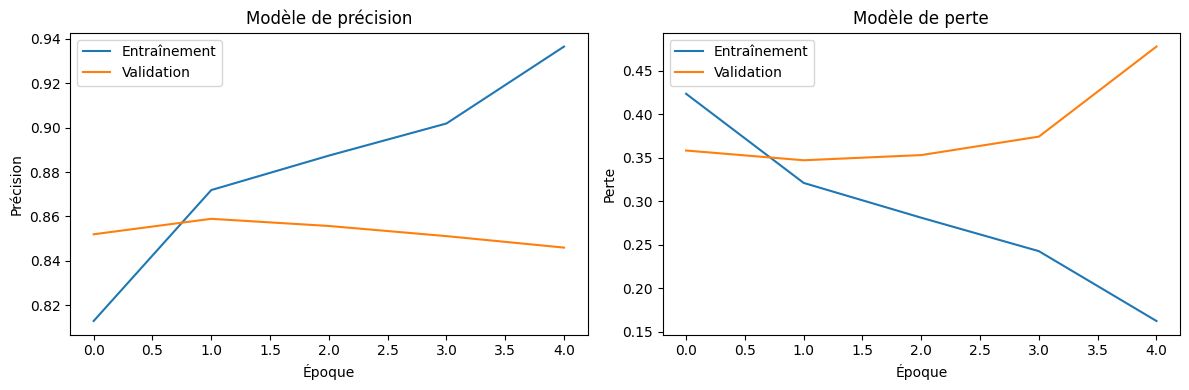

In [150]:
plot_learning_curves(history2)

In [151]:
plot_roc_curve(model_lstm_attention, X_val_padded, Y_val)

250/250 [==============================] - 1s 3ms/step


ValueError: Found array with dim 3. None expected <= 2.

##Modèle Transformer :

##Sauvegarde des Modèles